<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Cell-meta" data-toc-modified-id="Cell-meta-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Cell meta</a></span></li><li><span><a href="#Gene-meta" data-toc-modified-id="Gene-meta-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Gene meta</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>MCDS</a></span></li></ul></li><li><span><a href="#Filter-feature" data-toc-modified-id="Filter-feature-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Filter feature</a></span></li><li><span><a href="#Add-mC-rate" data-toc-modified-id="Add-mC-rate-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Add mC rate</a></span></li><li><span><a href="#Save-features" data-toc-modified-id="Save-features-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save features</a></span></li></ul></div>

In [1]:
from dask.distributed import Client
client = Client(dashboard_address=':46064')

In [2]:
import configparser
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
import xarray as xr
import warnings

from cemba_data.local.mc.prepare_study import prepare_study
from cemba_data.plot import *
from cemba_data.plot.preprocessing import *
from cemba_data.tools.hdf5.anndata import highly_variable_methylation_feature
from ALLCools.mcds.MCDS import MCDS
from cemba_data.tools.hdf5.anndata import rank_features_groups

# Per Region Coords and Cluster

In [3]:
result_dir = pathlib.Path()
result_dir.mkdir(exist_ok=True)
fig_dir = result_dir / 'fig'
fig_dir.mkdir(exist_ok=True)

## Parameters

In [4]:
regions = [
    '1A', '1B', '1C', '2A', '2B', '2C', '2D', '2E', '3A', '3B', '3C',
    '3D', '3E', '3F', '4A', '4B', '4C', '4D', '4E', '4F', '4G', '4H',
    '5A', '5B', '5C', '5D', '5E', '5F', '5G', '5H', '5J', '6A', '6B',
    '6C', '6D', '7B', '8B', '9H', '9J', '11E', '11F']
max_cell = 50000

In [5]:
project_dir = '/home/hanliu/project/mouse_rostral_brain/'

cell_meta_path = '/home/hanliu/project/mouse_rostral_brain/study/regional_qc/cell_meta.after_qc.msg'
gene_annotation_path = '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz'

clustering_feature = 'chrom100k'  # 100kb chromosome bins

# preprocess parameters
min_feature_cov, max_feature_cov = 500, 3000

ch_hvf_top = 3000
min_ch_hvf_mean = 0.5
max_ch_hvf_mean = 2.5

cg_hvf_top = 3000
min_cg_hvf_mean = 0.5
max_cg_hvf_mean = 1.2

ch_pc_components = 25
cg_pc_components = 14

n_neighbors = 25
resolution = 0.8

mch_gene_score_cutoff = 5
mch_abs_log_fold_change = 1
n_marker_genes = 500

In [6]:
project_dir = pathlib.Path(project_dir)

## Load data
### Cell meta

In [7]:
cell_meta = pd.read_msgpack(cell_meta_path)
cell_meta = cell_meta[cell_meta['PassFilter'] & cell_meta['Region'].isin(regions)]

if (max_cell is not None) and (max_cell <= cell_meta.shape[0]):
    cell_meta = cell_meta.sample(max_cell)
cell_meta.to_msgpack(result_dir / 'used_cells.msg')

### Gene meta

In [8]:
gene_meta = pd.read_csv(gene_annotation_path, index_col='gene_id', sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v:k for k, v in gene_meta['gene_name'].iteritems()}
gene_id_base_to_id = pd.Series(gene_meta.index, index = gene_meta.index.map(lambda i: i.split('.')[0])).to_dict()

### MCDS

In [9]:
# mcds_path
dataset_dir = project_dir / 'dataset'
mcds_path_list = [i for i in dataset_dir.glob('*mcds') if i.name.split('-')[0] in regions]

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mcds = MCDS.open(mcds_path_list, 
                     use_cells=cell_meta[cell_meta['PassFilter']].index,
                     chunks={'cell': 1000})

## Filter feature

In [11]:
mcds = mcds.sel(chrom100k=~mcds.coords[f'{clustering_feature}_chrom'].isin(['chrY', 'chrM']))

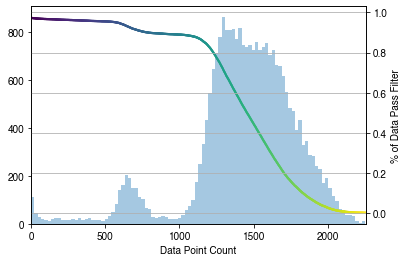

In [12]:
fig, axes = cutoff_vs_cell_remain(mcds[f'{clustering_feature}_da']\
                                  .sel(count_type='cov', mc_type='CHN')\
                                  .mean(axis=0)\
                                  .load())
fig.savefig(fig_dir / f'region_mean_CHN_cov.pdf')

In [13]:
before = mcds.coords[clustering_feature].size
mcds = mcds.filter_region_cov(dim=clustering_feature, 
                              da=f'{clustering_feature}_da', 
                              mc_type='CHN', 
                              min_cov=min_feature_cov, 
                              max_cov=max_feature_cov)
after = mcds.coords[clustering_feature].size
print(f'Filter {clustering_feature} by [{min_feature_cov}, {max_feature_cov}], '
      f'filter rate {(after / before):.2f}. {after} features remained.')

Filter chrom100k by [500, 3000], filter rate 0.96. 25169 features remained.


In [14]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 50000, chrom100k: 25169, count_type: 2, gene: 55487, mc_type: 2)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * gene                 (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000064372.1'
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) object dask.array<shape=(55487,), chunksize=(55487,)>
    gene_start           (gene) int64 dask.array<shape=(55487,), chunksize=(55487,)>
    gene_end             (gene) int64 dask.array<shape=(55487,), chunksize=(55487,)>
  * cell                 (cell) object '2C_M_1600' '4H_M_123' ... '5B_M_1876'
  * chrom100k            (chrom100k) int64 30 31 32 33 ... 26336 26337 26338
    chrom100k_chrom      (chrom100k) object dask.array<shape=(25169,), chunksize=(25169,)>
    chrom100k_bin_start  (chrom100k) int64 dask.array<shape=(25169,), chunksize=(25169,)>
    chrom100k_bin_end    (chrom100k) int64 dask.a

## Add mC rate

In [15]:
mcds.add_mc_rate(dim=clustering_feature, da=f'{clustering_feature}_da')

In [16]:
ch_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature, mc_type='CHN',
    min_disp=None, max_disp=None,
    min_mean=min_ch_hvf_mean, max_mean=max_ch_hvf_mean,
    n_top_feature=ch_hvf_top, bin_min_features=5,
    mean_binsize=0.05, cov_binsize=100)

distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker process 182880 was killed by signal 15
distributed.nanny - WARNING - Restarting worker
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU

Total Feature Number:     25169
Highly Variable Feature:  3000 (11.9%)


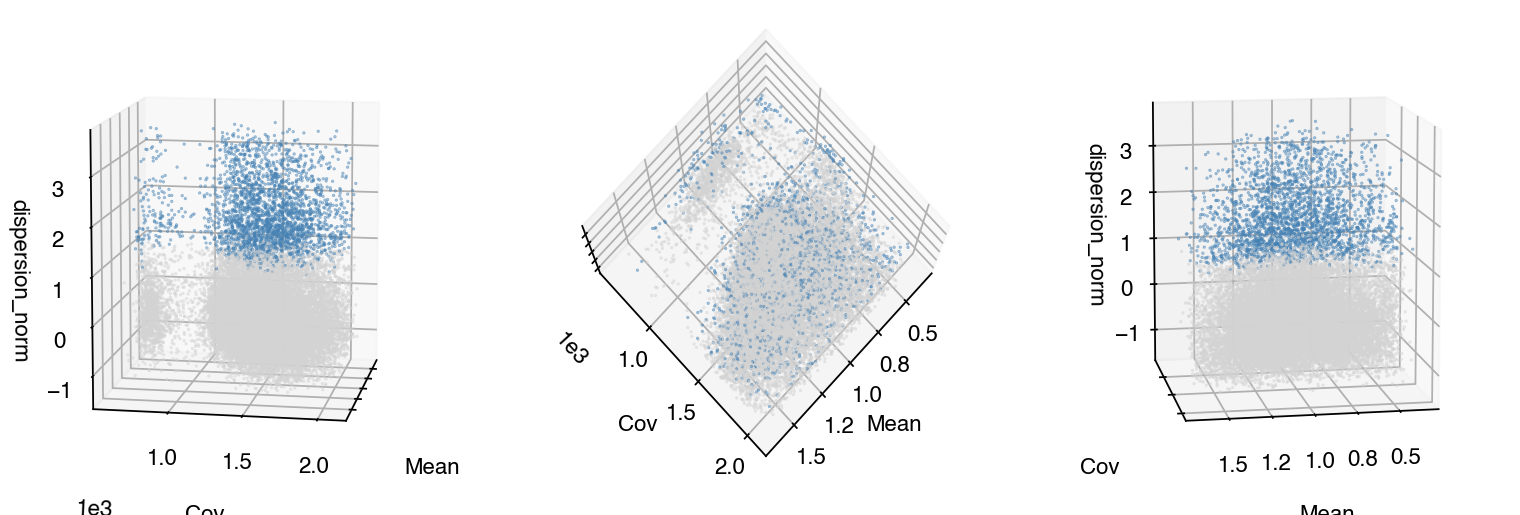

In [17]:
selection = ch_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)')

fig, axes = plot_dispersion(ch_hvf_df, hue='gene_subset',
                            zlab='dispersion_norm', data_quantile=(0.01, 0.99),
                            save_animate_path=None, fig_kws=None)
fig.savefig(fig_dir / f'ch_highly_variable_feature.{clustering_feature}.png', bbox_inches='tight')

In [18]:
cg_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature, mc_type='CGN',
    min_disp=None, max_disp=None,
    min_mean=min_cg_hvf_mean, max_mean=max_cg_hvf_mean,
    n_top_feature=cg_hvf_top, bin_min_features=5,
    mean_binsize=0.01, cov_binsize=10)

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Total Feature Number:     25169
Highly Variable Feature:  2999 (11.9%)


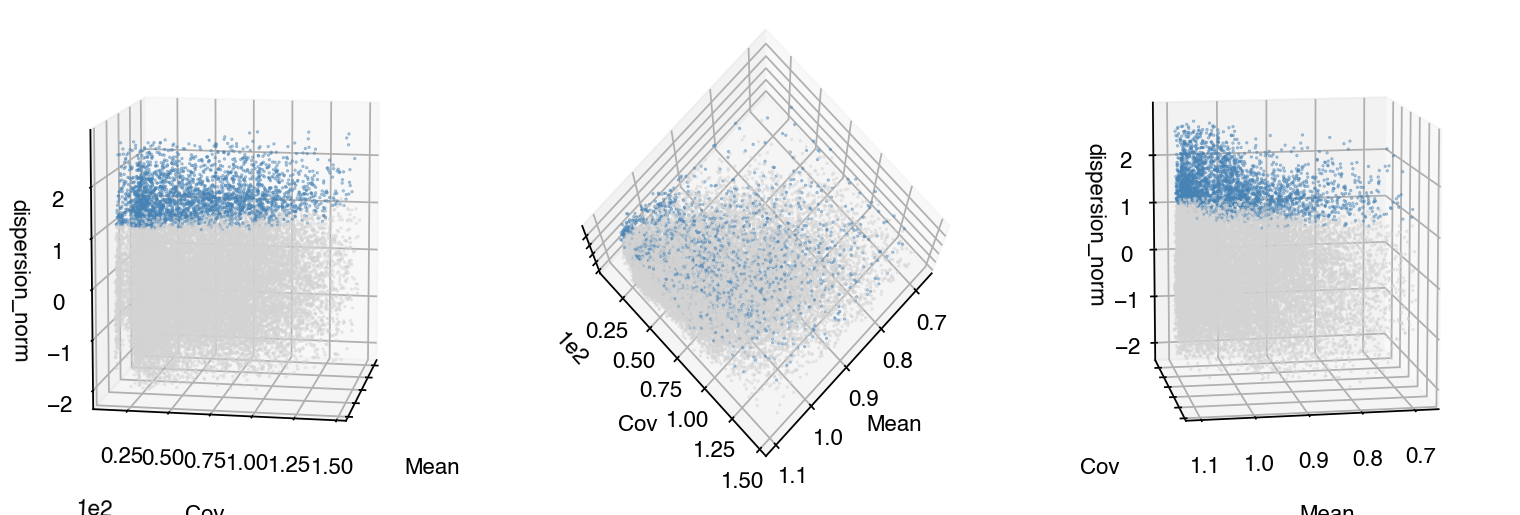

In [19]:
selection = cg_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)')

fig, axes = plot_dispersion(cg_hvf_df, hue='gene_subset',
                            zlab='dispersion_norm', data_quantile=(0.01, 0.99),
                            save_animate_path=None, fig_kws=None)
fig.savefig(fig_dir / f'cg_highly_variable_feature.{clustering_feature}.png', bbox_inches='tight')

## Save features

In [32]:
ch_hvf = ch_hvf_df[ch_hvf_df['gene_subset']].index
cg_hvf = cg_hvf_df[cg_hvf_df['gene_subset']].index
total_hvf = ch_hvf | cg_hvf

In [33]:
with open('total_hvf.txt', 'w') as f:
    f.write('\n'.join(total_hvf.astype(str).tolist()))
with open('ch_hvf.txt', 'w') as f:
    f.write('\n'.join(ch_hvf.astype(str).tolist()))
with open('cg_hvf.txt', 'w') as f:
    f.write('\n'.join(cg_hvf.astype(str).tolist()))